1. 在“LoRA 低秩适配 OpenAI Whisper-Large-V2 语音识别任务”中，为中文语料的训练过程增加过程评估，观察 Train Loss 和 Validation Loss 变化。

In [1]:
model_name_or_path = "openai/whisper-large-v2"
language = "Chinese (China)"
language_abbr = "zh-CN"
task = "transcribe"
dataset_name = "../../../datasets/common_voice_11_0"

batch_size=32

In [2]:
from datasets import load_dataset
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()

common_voice["train"] = load_dataset(dataset_name, language_abbr, split="train[:20%]")
common_voice["validation"] = load_dataset(dataset_name, language_abbr, split="test[:1%]")
common_voice["test"] = load_dataset(dataset_name, language_abbr, split="test[:20%]")
common_voice["train"][2]

/home/sheng/python-env/learn-llm/lib/python3.10/site-packages/datasets/load.py:922: FutureWarning: The repository for common_voice_11_0 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at ../../../datasets/common_voice_11_0/common_voice_11_0.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/home/sheng/python-env/learn-llm/lib/python3.10/site-packages/datasets/load.py:922: FutureWarning: The repository for common_voice_11_0 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at ../../../datasets/common_voice_11_0/common_voice_11_0.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset fr

{'client_id': '95368aab163e0387e4fd4991b4f2d8ccfbd4364bf656c860230501fd27dcedf087773e4695a6cf5de9c4f1d406d582283190d065cdfa36b0e2b060cffaca977e',
 'path': '/home/sheng/.cache/huggingface/datasets/downloads/extracted/cecfe1d6518799fb4de108d2f7e9d0831b4c648d9298b8a7079afa6627c2779e/zh-CN_train_0/common_voice_zh-CN_33211591.mp3',
 'audio': {'path': '/home/sheng/.cache/huggingface/datasets/downloads/extracted/cecfe1d6518799fb4de108d2f7e9d0831b4c648d9298b8a7079afa6627c2779e/zh-CN_train_0/common_voice_zh-CN_33211591.mp3',
  'array': array([-1.13686838e-13, -8.81072992e-13, -1.50635060e-12, ...,
         -1.20806035e-05, -9.51409311e-06, -4.57577698e-06]),
  'sampling_rate': 48000},
 'sentence': '汉代经济先后经历了繁荣和衰落两个极端的阶段。',
 'up_votes': 3,
 'down_votes': 2,
 'age': '',
 'gender': '',
 'accent': '',
 'locale': 'zh-CN',
 'segment': ''}

In [3]:
from transformers import AutoFeatureExtractor, AutoTokenizer, AutoProcessor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_name_or_path)

tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path, language=language, task=task)

processor = AutoProcessor.from_pretrained(
    model_name_or_path, language=language, task=task)

In [4]:
common_voice = common_voice.remove_columns(
    ["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"]
)
common_voice["train"][2]

{'audio': {'path': '/home/sheng/.cache/huggingface/datasets/downloads/extracted/cecfe1d6518799fb4de108d2f7e9d0831b4c648d9298b8a7079afa6627c2779e/zh-CN_train_0/common_voice_zh-CN_33211591.mp3',
  'array': array([-1.13686838e-13, -8.81072992e-13, -1.50635060e-12, ...,
         -1.20806035e-05, -9.51409311e-06, -4.57577698e-06]),
  'sampling_rate': 48000},
 'sentence': '汉代经济先后经历了繁荣和衰落两个极端的阶段。'}

In [5]:
from datasets import Audio

common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

In [6]:
def prepare_dataset(batch):
    audio = batch["audio"]
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

common_voice = common_voice.map(prepare_dataset, remove_columns=common_voice.column_names["train"])

Map:   0%|          | 0/5811 [00:00<?, ? examples/s]

Map:   0%|          | 0/2116 [00:00<?, ? examples/s]

In [7]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        label_features = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch


data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [8]:
from transformers import AutoModelForSpeechSeq2Seq

model = AutoModelForSpeechSeq2Seq.from_pretrained(model_name_or_path, load_in_8bit=True, device_map="auto")

model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

In [9]:
from peft import prepare_model_for_int8_training

model = prepare_model_for_int8_training(model)

/home/sheng/python-env/learn-llm/lib/python3.10/site-packages/peft/utils/other.py:141: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


In [10]:
from peft import LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=64,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none")

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 3,932,160 || all params: 1,547,237,120 || trainable%: 0.25414074863974306


In [11]:
from transformers import Seq2SeqTrainingArguments

# 设置序列到序列模型训练的参数
training_args = Seq2SeqTrainingArguments(
    output_dir="models/whisper-large-v2-asr-int8",  # 指定模型输出和保存的目录
    per_device_train_batch_size=batch_size,  # 每个设备上的训练批量大小
    gradient_accumulation_steps=1,  # 梯度累积步数，在每次优化器步骤之前累积的更新步数
    learning_rate=1e-4,  # 学习率
    warmup_steps=10,  # 在训练初期增加学习率的步数，有助于稳定训练
    # max_steps=620, # 训练总步数
    evaluation_strategy="steps",  # 设置评估策略，这里是在每个steps结束时进行评估
    eval_steps=10,  # 指定评估的步数
    num_train_epochs=3,  # 训练的总轮数
    # evaluation_strategy="epoch",  # 设置评估策略，这里是在每个epoch结束时进行评估
    fp16=True,  # 启用混合精度训练，可以提高训练速度，同时减少内存使用
    per_device_eval_batch_size=batch_size,  # 每个设备上的评估批量大小
    generation_max_length=64,  # 生成任务的最大长度
    logging_steps=3,  # 指定日志记录的步骤，用于跟踪训练进度
    remove_unused_columns=False,  # 是否删除不使用的列，以减少数据处理开销
    label_names=["labels"],  # 指定标签列的名称，用于训练过程中
)

In [12]:
from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR
from transformers import Seq2SeqTrainer, TrainerCallback, Seq2SeqTrainingArguments, TrainerState, TrainerControl
import os

class SavePeftModelCallback(TrainerCallback):
    def on_save(
        self,
        args: Seq2SeqTrainingArguments,
        state: TrainerState,
        control: TrainerControl,
        **kwargs,
    ):
        checkpoint_folder = os.path.join(args.output_dir, f"{PREFIX_CHECKPOINT_DIR}-{state.global_step}")

        peft_model_path = os.path.join(checkpoint_folder, "adapter_model")
        kwargs["model"].save_pretrained(peft_model_path)

        pytorch_model_path = os.path.join(checkpoint_folder, "pytorch_model.bin")
        if os.path.exists(pytorch_model_path):
            os.remove(pytorch_model_path)
        return control

In [13]:
common_voice

DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 5811
    })
    validation: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 106
    })
    test: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 2116
    })
})

In [14]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["validation"],
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,
    callbacks=[SavePeftModelCallback],
)
model.config.use_cache = False

In [15]:
trainer.train()

/home/sheng/python-env/learn-llm/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheng/python-env/learn-llm/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/sheng/python-env/learn-llm/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss
10,3.256800,2.377071
20,2.150300,1.833557
30,1.798500,1.634162
40,1.528900,1.475671
50,1.436400,1.329411
60,1.166800,1.203673
70,0.962000,1.034515
80,0.790400,0.827447
90,0.548200,0.803091
100,0.631100,0.796305


/home/sheng/python-env/learn-llm/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheng/python-env/learn-llm/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/sheng/python-env/learn-llm/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


TrainOutput(global_step=546, training_loss=0.7803414206365089, metrics={'train_runtime': 7106.477, 'train_samples_per_second': 2.453, 'train_steps_per_second': 0.077, 'total_flos': 3.71119514628096e+19, 'train_loss': 0.7803414206365089, 'epoch': 3.0})

In [19]:
model.save_pretrained("models/whisper-large-v2-asr-int8")

In [23]:
list(filter(lambda x: "loss" in x, trainer.state.log_history))

[{'loss': 4.8248, 'learning_rate': 1e-05, 'epoch': 0.02, 'step': 3},
 {'loss': 4.9368, 'learning_rate': 4e-05, 'epoch': 0.03, 'step': 6},
 {'loss': 3.2568, 'learning_rate': 7e-05, 'epoch': 0.05, 'step': 9},
 {'loss': 2.3589, 'learning_rate': 0.0001, 'epoch': 0.07, 'step': 12},
 {'loss': 2.0912,
  'learning_rate': 9.94402985074627e-05,
  'epoch': 0.08,
  'step': 15},
 {'loss': 2.1503,
  'learning_rate': 9.888059701492539e-05,
  'epoch': 0.1,
  'step': 18},
 {'loss': 2.0475,
  'learning_rate': 9.832089552238806e-05,
  'epoch': 0.12,
  'step': 21},
 {'loss': 1.6087,
  'learning_rate': 9.776119402985075e-05,
  'epoch': 0.13,
  'step': 24},
 {'loss': 1.9261,
  'learning_rate': 9.720149253731343e-05,
  'epoch': 0.15,
  'step': 27},
 {'loss': 1.7985,
  'learning_rate': 9.664179104477612e-05,
  'epoch': 0.16,
  'step': 30},
 {'loss': 1.6785,
  'learning_rate': 9.608208955223881e-05,
  'epoch': 0.18,
  'step': 33},
 {'loss': 1.5311,
  'learning_rate': 9.552238805970149e-05,
  'epoch': 0.2,
  's

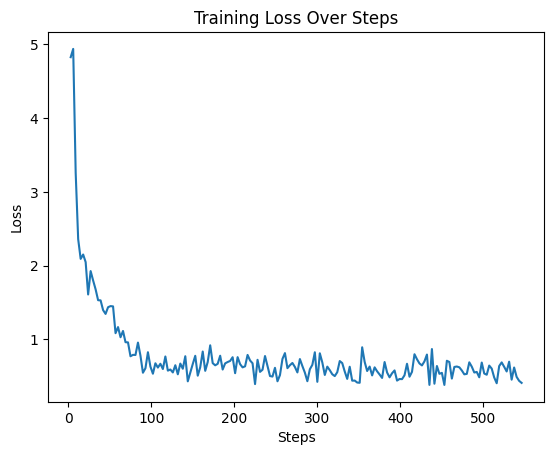

In [24]:
import matplotlib.pyplot as plt

# Get the training loss and steps from the log history
train_loss = [log["loss"] for log in list(filter(lambda x: "loss" in x, trainer.state.log_history))]
steps = [log["step"] for log in list(filter(lambda x: "loss" in x, trainer.state.log_history))]

# Plot the training loss
plt.plot(steps, train_loss)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Steps")
plt.show()


In [25]:
test_audio = "../../peft/data/audio/test_zh.flac"

from transformers import AutomaticSpeechRecognitionPipeline

pipeline = AutomaticSpeechRecognitionPipeline(model=model, tokenizer=tokenizer, feature_extractor=feature_extractor)

forced_decoder_ids = processor.get_decoder_prompt_ids(language="chinese", task=task)

The model 'PeftModel' is not supported for . Supported models are ['Pop2PianoForConditionalGeneration', 'SeamlessM4TForSpeechToText', 'SeamlessM4Tv2ForSpeechToText', 'SpeechEncoderDecoderModel', 'Speech2TextForConditionalGeneration', 'SpeechT5ForSpeechToText', 'WhisperForConditionalGeneration', 'Data2VecAudioForCTC', 'HubertForCTC', 'MCTCTForCTC', 'SEWForCTC', 'SEWDForCTC', 'UniSpeechForCTC', 'UniSpeechSatForCTC', 'Wav2Vec2ForCTC', 'Wav2Vec2ConformerForCTC', 'WavLMForCTC'].


In [26]:
with torch.cuda.amp.autocast():
    text = pipeline(test_audio, generate_kwargs={"forced_decoder_ids": forced_decoder_ids}, max_new_tokens=255)["text"]

print(text)

/home/sheng/python-env/learn-llm/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheng/python-env/learn-llm/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/sheng/python-env/learn-llm/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
`use_cache = True` is incompatible

这是一段测试用于WhisperLarge V2模型的自动语音识别测试。


2. 在“LoRA 低秩适配 OpenAI Whisper-Large-V2 语音识别任务”中，当 LoRA 模型训练完成后，使用测试集进行完整的模型评估

In [27]:
import evaluate

# 词错误率（WER）是评估ASR模型常用的指标。从 Evaluate加载 WER 指标
metric = evaluate.load("wer")

from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import gc

eval_dataloader = DataLoader(common_voice["test"], batch_size=8, collate_fn=data_collator)

model.eval()

PeftModel(
  (base_model): LoraModel(
    (model): WhisperForConditionalGeneration(
      (model): WhisperModel(
        (encoder): WhisperEncoder(
          (conv1): Conv1d(80, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
          (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
          (embed_positions): Embedding(1500, 1280)
          (layers): ModuleList(
            (0-31): 32 x WhisperEncoderLayer(
              (self_attn): WhisperSdpaAttention(
                (k_proj): Linear8bitLt(in_features=1280, out_features=1280, bias=False)
                (v_proj): lora.Linear8bitLt(
                  (base_layer): Linear8bitLt(in_features=1280, out_features=1280, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=8, bias=False)
                  )
            

In [28]:
for step, batch in enumerate(tqdm(eval_dataloader)):
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            generated_tokens = (
                model.generate(
                    input_features=batch["input_features"].to("cuda"),
                    decoder_input_ids=batch["labels"][:, :4].to("cuda"),
                    max_new_tokens=255,
                )
                .cpu()
                .numpy()
            )
            labels = batch["labels"].cpu().numpy()
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
            metric.add_batch(
                predictions=decoded_preds,
                references=decoded_labels,
            )
    del generated_tokens, labels, batch
    gc.collect()


100%|██████████| 265/265 [56:05<00:00, 12.70s/it] 


In [29]:

wer = 100 * metric.compute()
print(f"{wer=}")

wer=62.19281663516069
